In [ ]:
## Homework # 2 AI 240 Machine Learning Course
### Instructor - Dr. Uma Gajendragadkar

### Student - Huy Le huy.le@bellevuecollege.edu

##  Classification Heart Disease Predication 
 
### Problem - Design and develop a Machine learning model that can help
### in making predictions that may be useful for
### doctors and healthcare providers to predict potential heart disease cases early on.

In [ ]:
## Setup and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
)

# Load data
df = pd.read_csv("./heart.csv")
print("Shape:", df.shape)
df.head(10)

Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [ ]:
## Look at data

In [3]:
display(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [ ]:
## Train/Test Split

In [7]:
target_col = "target" if "target" in df.columns else df.columns[-1]

# Separate features and labels
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# Columns
possible_cats = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
categorical_cols = [c for c in possible_cats if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numeric: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Train size: (820, 13)
Test size: (205, 13)


In [ ]:
## 4. Preprocessing Pipeline and Logistic Regression

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Model
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")

pipe = Pipeline(steps=[("preprocess", preprocess),
                      ("model", log_reg)])

# 5-fold CV on training data, which was shown in the w3schools-style intro
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print("5-fold CV Accuracy:", cv_scores.round(4))
print("Mean:", cv_scores.mean().round(4))

5-fold CV Accuracy: [0.8902 0.8598 0.8476 0.8537 0.8537]
Mean: 0.861


In [ ]:
## 5. Fit the Model and Predict

In [11]:
pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("First 10 predicted labels:", y_pred[:10])
print("First 10 predicted probabilities:", y_prob[:10].round(3))

First 10 predicted labels: [0 0 0 1 0 0 1 0 1 0]
First 10 predicted probabilities: [0.028 0.311 0.002 0.533 0.132 0.015 0.756 0.275 0.982 0.311]


In [ ]:
## 6. Confusion Matrix (based on w3schools)

Confusion Matrix:
 [[84 16]
 [10 95]]


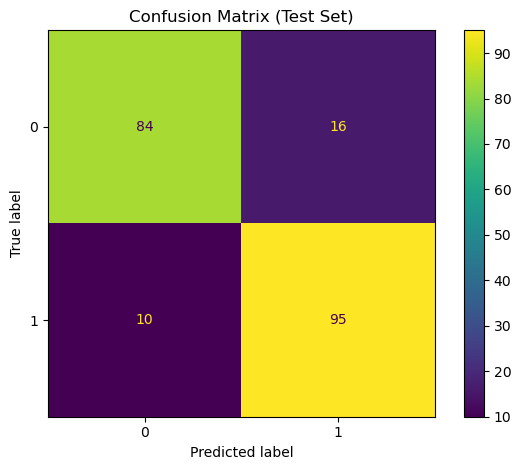

In [12]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [ ]:
## 7. Metrics like Accuracy, Precision, Recall, F1, ROC AUC

Accuracy:  0.8732
Precision: 0.8559
Recall:    0.9048
F1-score:  0.8796
ROC AUC:   0.9445

Classification Report:
              precision    recall  f1-score   support

           0     0.8936    0.8400    0.8660       100
           1     0.8559    0.9048    0.8796       105

    accuracy                         0.8732       205
   macro avg     0.8747    0.8724    0.8728       205
weighted avg     0.8743    0.8732    0.8730       205



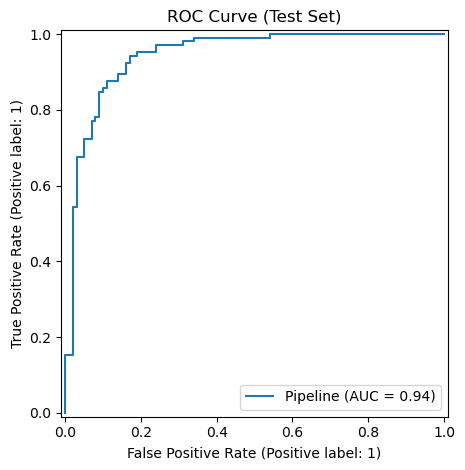

In [13]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("ROC Curve (Test Set)")
plt.tight_layout()
plt.show()

In [ ]:
## 8. Feature Coefficients

In [14]:
# Extract feature names after preprocessing
ct = pipe.named_steps["preprocess"]
ohe = ct.named_transformers_["cat"].named_steps["onehot"] if len(categorical_cols) else None
num_feats = numeric_cols
cat_feats = list(ohe.get_feature_names_out(categorical_cols)) if ohe is not None else []
feature_names = num_feats + cat_feats

coefs = pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df["|coef|"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("|coef|", ascending=False).drop(columns=["|coef|"])
coef_df.head(20)

,feature,coefficient
23,ca_2,-1.717396
25,ca_4,1.484594
21,ca_0,1.372229
7,cp_0,-1.227727
6,sex_1,-0.824821
5,sex_0,0.812502
9,cp_2,0.770783
10,cp_3,0.764883
29,thal_3,-0.677806
20,slope_2,0.642428


In [ ]:
## Conclusion 

I developed a Logistic Regression model to help with early prediction of
heart disease based on patient health indicators. I preprocess the data
using imputation and feature scaling, and used the supervised learning approach
for training.

I used accuracy, precision, recall, F1-score, ROC AUC, and a confusion matrix.
I observed that the model performs well at identifying patients who may be
at risk.

Logistic Regression was good for this data because of the interpretable
coefficients. 

If chest pain = 3, chest pain that is more severe like asymptomatic
would likely be predicted to have heart disease.
Blocked vessels or ca >= 1 often had target = 1.
exang = 1 had heart disease cases.
oldpeak would also tend to be higher.
thalach < 140 would often have a heart disease target = 1 because of
the lower peak heart rate.
thal = 2 would be common with target = 1.